# Libraries

In [104]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

Training Set:
        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bitterswee

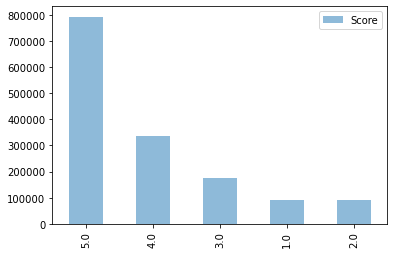


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [105]:
import csv

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print("Training Set:")
print(trainingSet.head())
print()
print("Testing Set:")
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")


In [106]:
def check_missing(df):
    
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_data_df = check_missing(trainingSet)
missing_data_test = check_missing(testingSet)
print('Missing data in train set:' , missing_data_df.head())
print('Missing data in test set:'  ,missing_data_test.head())

Missing data in train set:             Total    Percent
Score      212192  12.500022
Text           62   0.003652
Summary        32   0.001885
Id              0   0.000000
ProductId       0   0.000000
Missing data in test set:         Total  Percent
Score  212192    100.0
Id          0      0.0


# Adding Features

In [107]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Load the embeddings, using word2vec.txt from Lecture 8
def load_embeddings(filepath):
    print("in load_embeddings")
    word_vectors = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            word_vectors[word] = vector
    return word_vectors
word_vectors = load_embeddings('./data/word2vec.txt')

# Compute weighted embedding for a single document
def get_weighted_embedding(text, tfidf_vector, vectorizer, word_vectors):
    words = text.split()
    embedding = np.zeros(300)  # Assuming 300-dimensional embeddings
    total_weight = 0.0

    for word in words:
        if word in vectorizer.vocabulary_ and word in word_vectors:
            tfidf_weight = tfidf_vector[0, vectorizer.vocabulary_[word]]
            embedding += tfidf_weight * word_vectors[word]
            total_weight += tfidf_weight

    if total_weight > 0:
        embedding /= total_weight

    return embedding

# For preprocessing text
def preprocess_text(text):
    # Initialize necessary components
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')  # Tokenizes words only
    stop_words = set(stopwords.words('english'))

    # Lowercase and remove punctuation
    text = text.lower()
    
    # Tokenize and lemmatize
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Join tokens back to a single string
    return " ".join(tokens)

# For improving sentiment analysis
def sentiment_analysis(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

def add_features_to(df):
    print("Starting add_features_to()")
    # This is where you can do all your feature extraction
    
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Preprocess Text
    print("Pre-processing Text")
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')
    df['CombinedText'] = df['Text'] + " " + df['Summary']
    df['ProcessedText'] = df['CombinedText'].apply(preprocess_text)

    # Add sentiment features
    df['SentimentPolarity'], df['SentimentSubjectivity'] = zip(*df['ProcessedText'].apply(sentiment_analysis))

    # Text Length Feature
    df['TextLength'] = df['ProcessedText'].apply(lambda x: len(x.split()))

    # TF-IDF
    print("Startng TF-IDF")
    vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
    tfidf_matrix = vectorizer.fit_transform(df['ProcessedText'])
    normalized_tfidf = tfidf_matrix / tfidf_matrix.max()
    print("Finished TF-IDF")

    # centered_dtm = tfidf_matrix - np.mean(tfidf_matrix, axis=0)
    # u, s, vt = np.linalg.svd(centered_dtm.toarray(), full_matrices=False)

    # Weighted embeddings
    print("Starting embeddings")
    embeddings = []
    for i, text in enumerate(df['ProcessedText']):
        tfidf_vector = normalized_tfidf[i]
        weighted_embedding = get_weighted_embedding(text, tfidf_vector, vectorizer, word_vectors)
        embeddings.append(weighted_embedding)
    df['WeightedEmbedding'] = embeddings
    print("Completed Embeddings")

    # Converts object to numeric
    df['WeightedEmbedding'] = df['WeightedEmbedding'].apply(lambda x: np.mean(x, axis=0))

    # Check if any NaN values exist in the final DataFrame
    if df.isnull().values.any():
        print("Warning: NaN values detected in DataFrame after processing.")
        df.fillna(0, inplace=True)  # or handle accordingly

    print("add_features_to done")
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    # sampled_train = trainingSet.sample(n=20000, random_state=42)
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nataliecheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nataliecheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nataliecheng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nataliecheng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


in load_embeddings
Starting add_features_to()
Pre-processing Text
Startng TF-IDF
Finished TF-IDF
Starting embeddings
Completed Embeddings
add_features_to done


# Sample + Split into training and testing set

In [108]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [109]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness',
            'SentimentPolarity', 'SentimentSubjectivity', 'TextLength', 'WeightedEmbedding']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

In [110]:
missing_data_df = check_missing(X_train_select)
missing_data_test = check_missing(X_test_select)
print('Missing data in train set:' , missing_data_df.head())
print()
print('Missing data in test set:'  ,missing_data_test.head())
print()
print("X_train_select shape:", X_train_select.shape)
print("Y_train shape:", Y_train.shape)
print("Y_train type:", type(Y_train))
print("X_submission_select shape:", X_submission_select.shape)
print()
print("Data types in X_train_select:\n", X_train_select.dtypes)


Missing data in train set:                         Total  Percent
HelpfulnessNumerator        0      0.0
HelpfulnessDenominator      0      0.0
Time                        0      0.0
Helpfulness                 0      0.0
SentimentPolarity           0      0.0

Missing data in test set:                         Total  Percent
HelpfulnessNumerator        0      0.0
HelpfulnessDenominator      0      0.0
Time                        0      0.0
Helpfulness                 0      0.0
SentimentPolarity           0      0.0

X_train_select shape: (1273149, 8)
Y_train shape: (1273149,)
Y_train type: <class 'pandas.core.series.Series'>
X_submission_select shape: (212192, 8)

Data types in X_train_select:
 HelpfulnessNumerator        int64
HelpfulnessDenominator      int64
Time                        int64
Helpfulness               float64
SentimentPolarity         float64
SentimentSubjectivity     float64
TextLength                  int64
WeightedEmbedding         float64
dtype: object


# Model Creation

In [ ]:
# Finding best params
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# For Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=rf_param_grid,
                               scoring='accuracy',  
                               cv=5,  # 5-fold cross-validation  
                               n_jobs=-1)  

rf_grid_search.fit(X_train_select, Y_train)

# Get the best parameters and best score
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best cross-validated score:", rf_grid_search.best_score_)

# For KNN
knn_param_grid = {
    'n_neighbors': [100, 200, 300],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
}

knn_grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                               param_grid=knn_param_grid,
                               scoring='accuracy', 
                               cv=5,  # 5-fold cross-validation  
                               n_jobs=-1)  

knn_grid_search.fit(X_train_select, Y_train)

# Get the best parameters and best score
print("Best parameters for KNN:", knn_grid_search.best_params_)
print("Best cross-validated score:", knn_grid_search.best_score_)


In [111]:
# Learn the model
model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10, min_samples_leaf=4, min_samples_split=10)
model.fit(X_train_select, Y_train)
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.4960860918413512


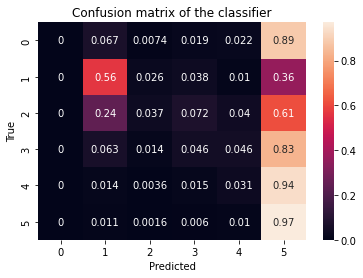

Classification Report: 


/Users/nataliecheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nataliecheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     52924
         1.0       0.46      0.56      0.51     22896
         2.0       0.27      0.04      0.07     22427
         3.0       0.26      0.05      0.08     44034
         4.0       0.29      0.03      0.06     84142
         5.0       0.51      0.97      0.67    197961

    accuracy                           0.50    424384
   macro avg       0.30      0.27      0.23    424384
weighted avg       0.36      0.50      0.36    424384



/Users/nataliecheng/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report: ")
print(classification_report(Y_test, Y_test_predictions))

# Create submission file

In [113]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
print("Number of rows:", submission.shape[0])

Number of rows: 212192
